In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import metacells as mc
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb

from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
sb.set_style("white")

/tmp/6832796.1.all.q/ipykernel_32605/597048702.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
raw = ad.read_h5ad("/net/mraid14/export/tgdata/users/hernan/wd_NEW/scrna_db/cells.SynEmb3.h5ad")
print(raw.shape)


(8832, 30324)


In [3]:
mc.pl.analyze_clean_genes(raw,
                          excluded_gene_patterns=["Xist"],
                          random_seed=123456)

set unnamed.var[properly_sampled_gene]: 20143 true (66.43%) out of 30324 bools
set unnamed.var[excluded_gene]: 1 true (0.003298%) out of 30324 bools
set unnamed.var[noisy_lonely_gene]: 0 true (0%) out of 30324 bools


In [4]:
mc.pl.pick_clean_genes(raw)

set unnamed.var[clean_gene]: 20142 true (66.42%) out of 30324 bools


In [5]:
full = raw

/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Will exclude 1080 (12.23%) cells with less than 1500 UMIs
Will exclude 137 (1.55%) cells with more than 20000 UMIs


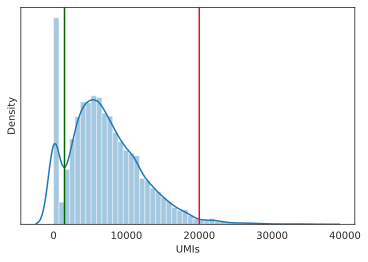

In [8]:
properly_sampled_min_cell_total = 1500
properly_sampled_max_cell_total = 20000

total_umis_of_cells = mc.ut.get_o_numpy(full, name='__x__', sum=True)

plot = sb.distplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')

too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))

/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Will exclude 0 (0.00%) cells with more than 10.00% excluded gene UMIs


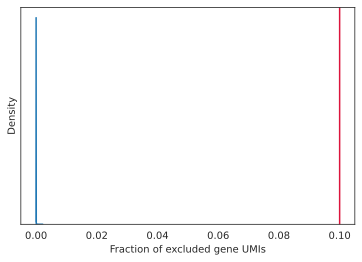

In [9]:
properly_sampled_max_excluded_genes_fraction = 0.1

excluded_genes_data = mc.tl.filter_data(full, var_masks=['~clean_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

plot = sb.distplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')

too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)

too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

In [10]:
mc.pl.analyze_clean_cells(
    full,
    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction)

set unnamed.obs[properly_sampled_cell]: 7615 true (86.22%) out of 8832 bools


In [11]:
mc.pl.pick_clean_cells(full)

set unnamed.obs[clean_cell]: 7615 true (86.22%) out of 8832 bools


In [12]:
clean = mc.pl.extract_clean_data(full)

set clean.obs[full_cell_index]: 7615 int64s
set clean.var[full_gene_index]: 20142 int64s


In [13]:
suspect_gene_names = ['PCNA', 'MKI67', 'TOP2A', 'UBE2C','GAS2L3',
                      'FOS', 'JUN', 'HSP90AB1', 'HSPA1A','CENPF',
                      'ISG15', 'WARS' , 'HBEGF', 'PMAIP', 'RRM2','PRC1','HBB-B1']

suspect_gene_patterns = ['BEX.*','PSMB.*', 'HSP.*', 'MT.*', 'RPL.*', 
                         'RPS.*','CCN.*','CDK.*','RPS.*','RN[0-9].*',
                         'MRP.*','NDUF.*','HIST.*']
suspect_genes_mask = mc.tl.find_named_genes(clean, names=suspect_gene_names,
                                            patterns=suspect_gene_patterns)
suspect_gene_names = sorted(clean.var_names[suspect_genes_mask])

In [14]:
mc.pl.relate_genes(clean, random_seed=123456)

set clean.var[related_genes_module]: 17935 outliers (89.04%) out of 20142 int32 elements with 137 groups with mean size 16.11
set clean.varp[related_genes_similarity]: csr_matrix 20142 X 20142 float32s (4870849 > 0)


In [15]:
module_of_genes = clean.var['related_genes_module']
suspect_gene_modules = np.unique(module_of_genes[suspect_genes_mask])
suspect_gene_modules = suspect_gene_modules[suspect_gene_modules >= 0]
suspect_gene_modules

array([  5,   9,  15,  17,  25,  29,  36,  38,  51,  53,  54,  56,  59,
        62,  63,  65,  69,  70,  75,  82,  84,  86,  87,  89,  91,  94,
        96,  98, 101, 109, 118, 119, 121, 124, 129, 131], dtype=int32)

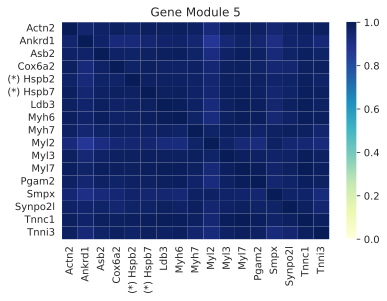

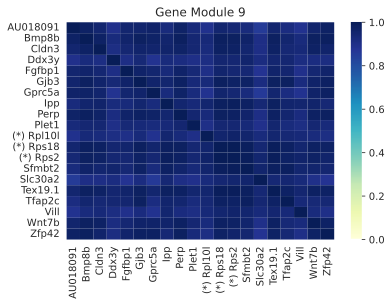

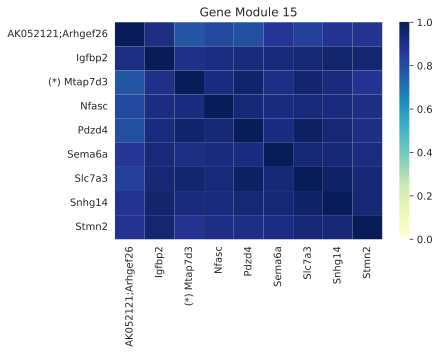

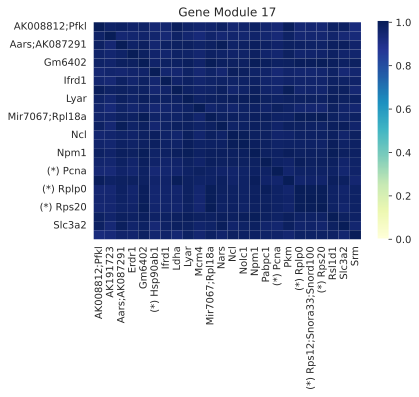

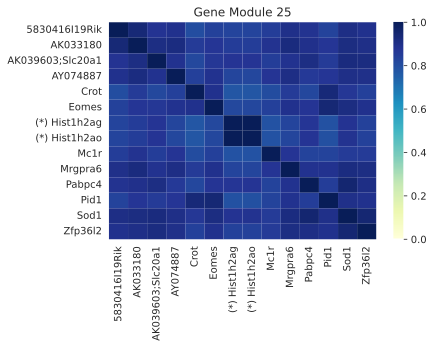

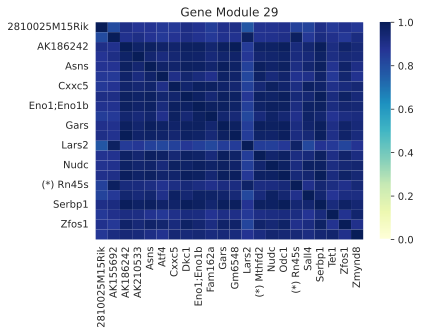

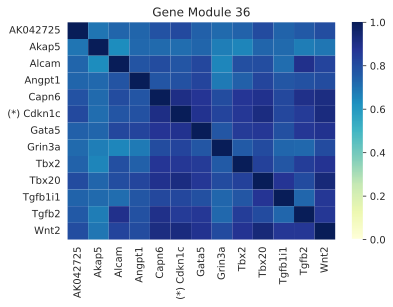

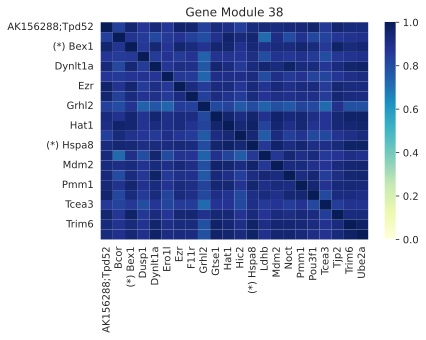

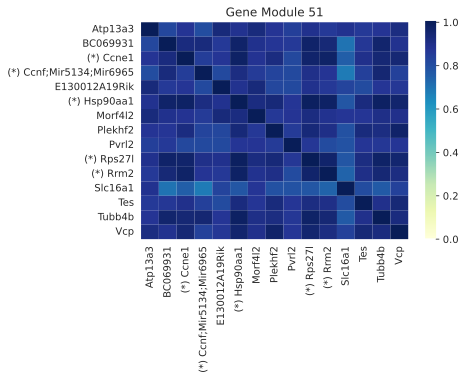

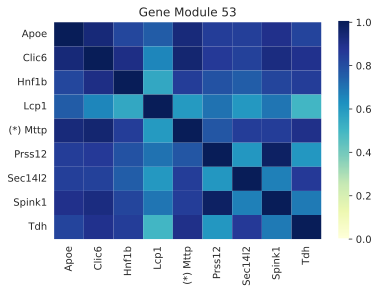

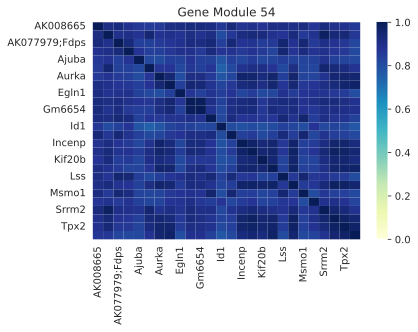

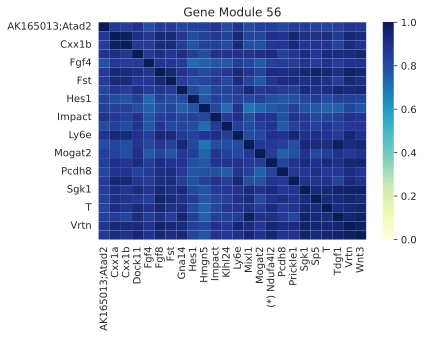

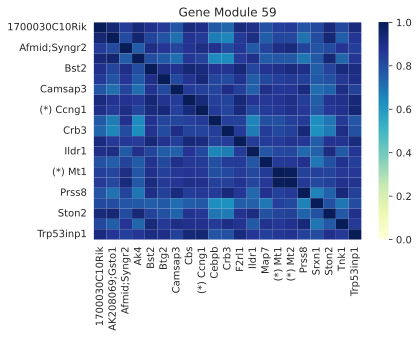

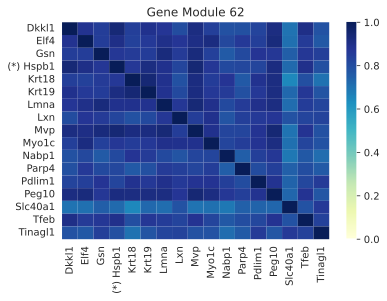

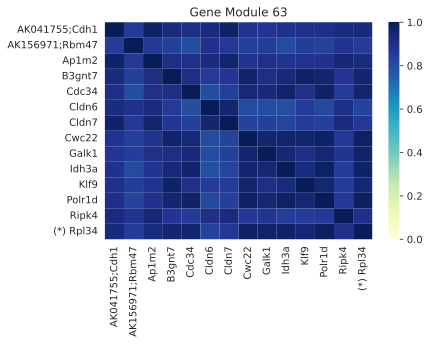

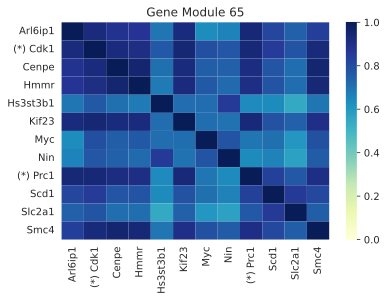

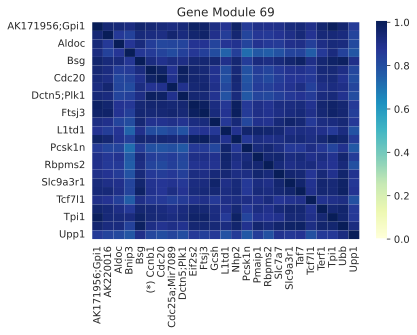

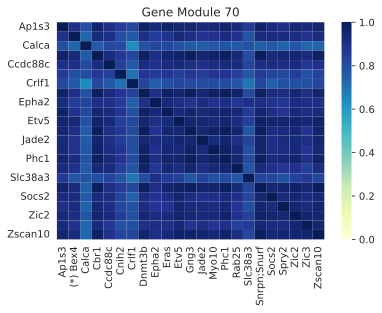

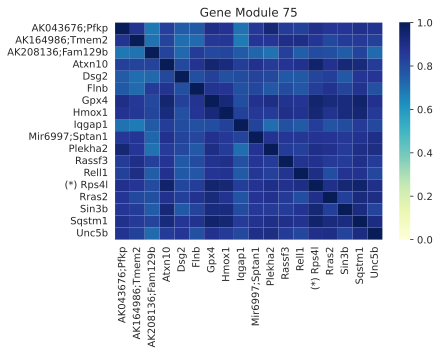

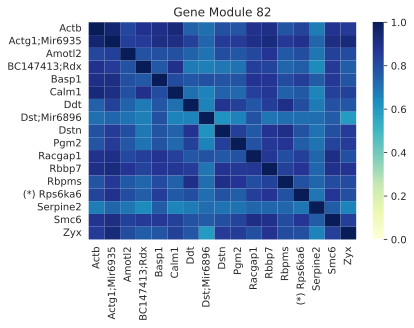

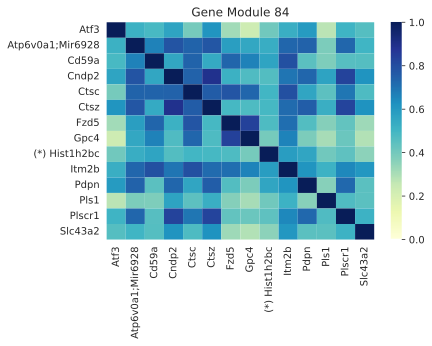

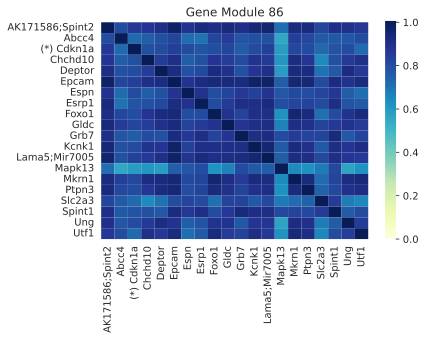

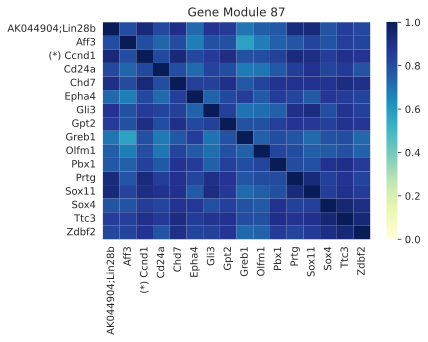

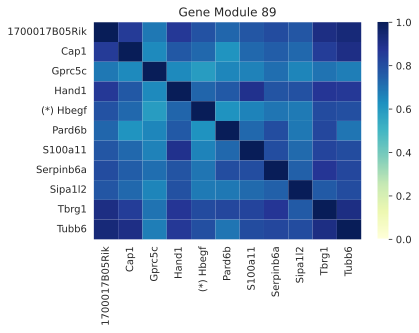

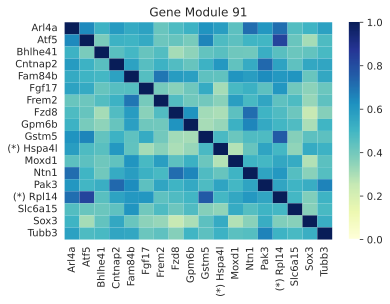

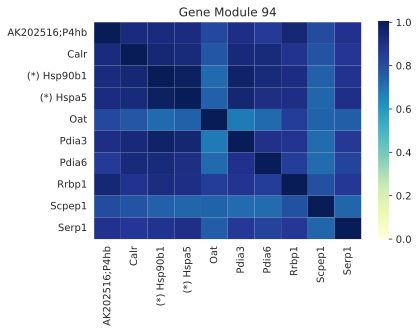

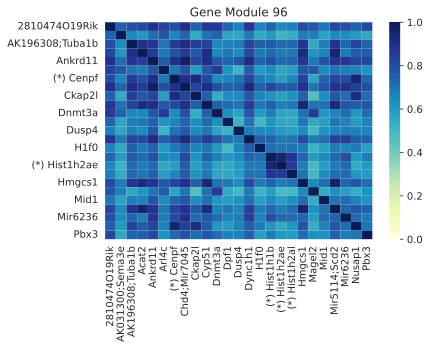

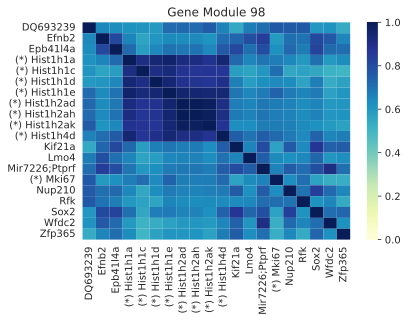

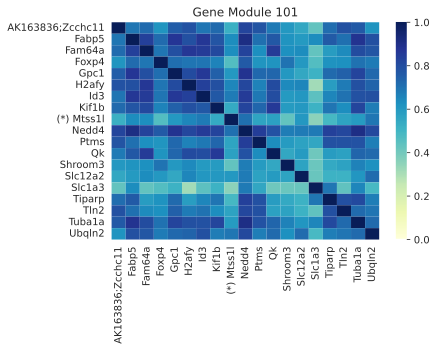

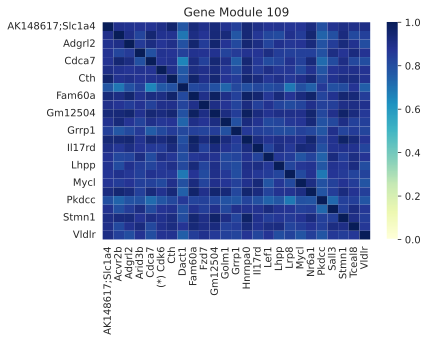

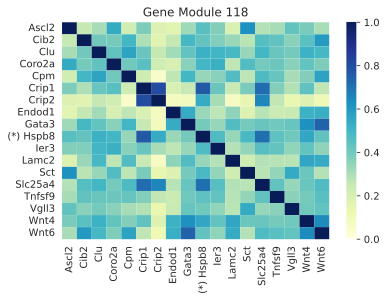

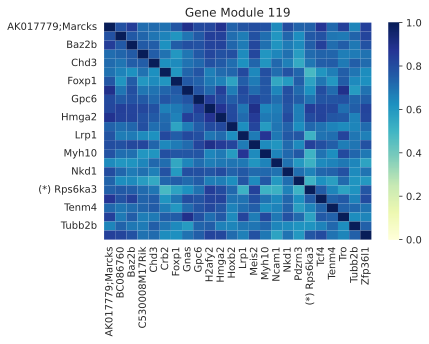

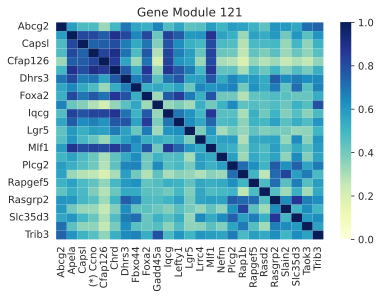

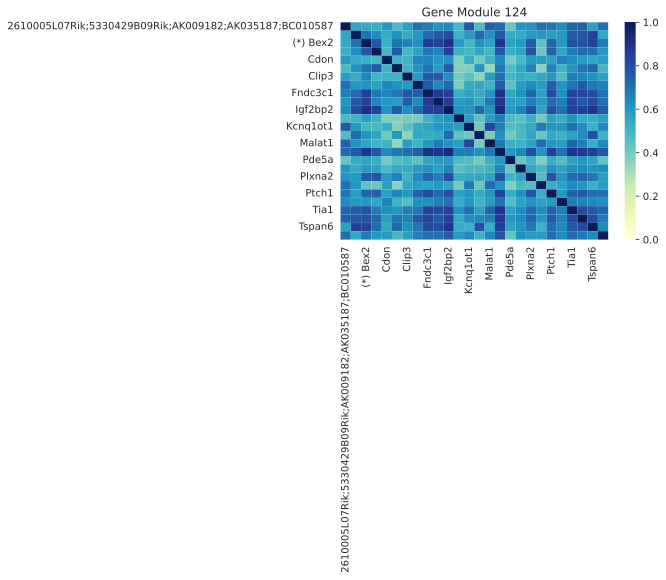

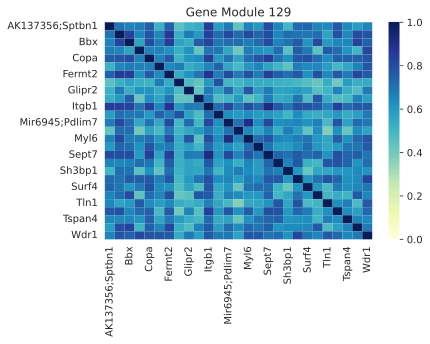

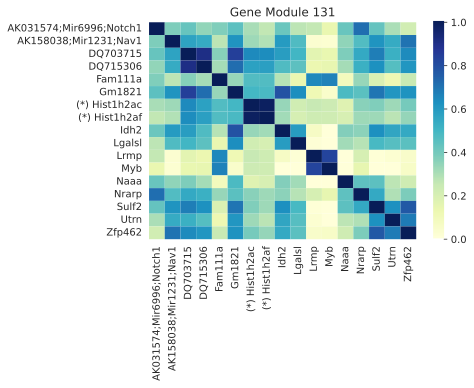

In [16]:
similarity_of_genes = mc.ut.get_vv_frame(clean, 'related_genes_similarity')
for gene_module in suspect_gene_modules:
    module_genes_mask = module_of_genes == gene_module
    similarity_of_module = similarity_of_genes.loc[module_genes_mask, module_genes_mask]
    similarity_of_module.index = \
    similarity_of_module.columns = [
        '(*) ' + name if name in suspect_gene_names else name
        for name in similarity_of_module.index
    ]
    ax = plt.axes()
    sb.heatmap(similarity_of_module, vmin=0, vmax=1, ax=ax, cmap="YlGnBu")
    ax.set_title(f'Gene Module {gene_module}')
    plt.show()

In [17]:
new_suspect_gene_modules = [5,9,15,17,51,65,86,91,94,96,98,101]

In [18]:
forbidden_genes_mask = suspect_genes_mask
for gene_module in new_suspect_gene_modules:
    module_genes_mask = module_of_genes == gene_module
    forbidden_genes_mask |= module_genes_mask
forbidden_gene_names = sorted(clean.var_names[forbidden_genes_mask])
print(len(forbidden_gene_names))
print(' '.join(forbidden_gene_names))

625
2810474O19Rik AK008812;Pfkl AK031300;Sema3e AK052121;Arhgef26 AK163836;Zcchc11 AK171586;Spint2 AK191723 AK196308;Tuba1b AK202516;P4hb AU018091 Aars;AK087291 Abcc4 Acat2 Actn2 Ankrd1 Ankrd11 Arl4a Arl4c Arl6ip1 Asb2 Atf5 Atp13a3 BC069931 Bex1 Bex2 Bex4 Bex6 Bhlhe41 Bmp8b Calr Ccna1 Ccna2 Ccnb1 Ccnb1ip1 Ccnb2 Ccnb3 Ccnc Ccnd1 Ccndbp1 Ccne1 Ccne2 Ccnf;Mir5134;Mir6965 Ccng1 Ccng2 Ccnh Ccni Ccnj Ccnjl Ccnk Ccnl1 Ccnl2 Ccno Ccnt1 Ccnt2 Ccny Ccnyl1 Cdk1 Cdk10 Cdk11b Cdk13 Cdk14 Cdk15 Cdk17;Pctk2 Cdk18 Cdk19 Cdk2 Cdk20 Cdk2ap1 Cdk2ap2 Cdk3-ps Cdk4 Cdk5 Cdk5r1 Cdk5r2 Cdk5rap1 Cdk5rap2 Cdk6 Cdk7 Cdk9 Cdkal1 Cdkl1 Cdkl2 Cdkl3 Cdkl4 Cdkn1a Cdkn1b Cdkn1c Cdkn2a Cdkn2aip Cdkn2aipnl Cdkn2b Cdkn2c Cdkn2d Cdkn3 Cenpe Cenpf Chchd10 Chd4;Mir7045 Ckap2l Cldn3 Cntnap2 Cox6a2 Cyp51 DQ693239 Ddx3y Deptor Dnmt3a Dpf1 Dusp4 Dync1h1 E130012A19Rik Efnb2 Epb41l4a Epcam Erdr1 Espn Esrp1 Fabp5 Fam64a Fam84b Fgf17 Fgfbp1 Fos Foxo1 Foxp4 Frem2 Fzd8 Gas2l3 Gjb3 Gldc Gm6402 Gpc1 Gpm6b Gprc5a Grb7 Gstm5 H1f0 H2afy H

In [19]:
max_parallel_piles = mc.pl.guess_max_parallel_piles(clean)
print(max_parallel_piles)
mc.pl.set_max_parallel_piles(max_parallel_piles)

115


In [21]:
mc.pl.divide_and_conquer_pipeline(clean,
                                  forbidden_gene_names = forbidden_gene_names,
                                  target_metacell_size = 125000, # ~30 CELLS WITH A MEDIAN UMI OF 4163
                                  random_seed = 123456)

set clean.var[rare_gene]: 0 true (0%) out of 20142 bools
set clean.var[rare_gene_module]: 20142 int32 elements with all outliers (100%)
set clean.obs[cells_rare_gene_module]: 7615 int32 elements with all outliers (100%)
set clean.obs[rare_cell]: 0 true (0%) out of 7615 bools
set clean.layers[downsampled]: ndarray 7615 X 20142 float32s
set clean.uns[downsample_samples]: 2481
set clean.var[high_top3_gene]: 2243 true (11.14%) out of 20142 bools
set clean.var[high_total_gene]: 11854 true (58.85%) out of 20142 bools
set clean.var[high_relative_variance_gene]: 3004 true (14.91%) out of 20142 bools
set clean.var[forbidden_gene]: 625 true (3.103%) out of 20142 bools
set clean.var[feature_gene]: 807 true (4.007%) out of 20142 bools
set clean.obsp[obs_similarity]: ndarray 7615 X 7615 float32s
set clean.obsp[obs_outgoing_weights]: csr_matrix 7615 X 7615 float32s (224474 > 0)
set clean.obs[seed]: 960 outliers (12.61%) out of 7615 int32 elements with 343 groups with mean size 19.4
set clean.obs[can

In [22]:
metacells = mc.pl.collect_metacells(clean, name='PBMC.metacells')

set PBMC.metacells.var[excluded_gene]: 0 true (0%) out of 20142 bools
set PBMC.metacells.var[clean_gene]: 20142 true (100%) out of 20142 bools
set PBMC.metacells.var[forbidden_gene]: 625 true (3.103%) out of 20142 bools
set PBMC.metacells.var[pre_feature_gene]: 0 positive (0%) out of 20142 int32s
set PBMC.metacells.var[feature_gene]: 807 positive (4.007%) out of 20142 int32s
set PBMC.metacells.obs[pile]: 363 int32s
set PBMC.metacells.obs[candidate]: 363 int32s


set PBMC.metacells.var[top_feature_gene]: 807 true (4.007%) out of 20142 bools
set PBMC.metacells.obsp[obs_balanced_ranks]: 4440 nonzero (3.37%) out of 131769 elements
set PBMC.metacells.obsp[obs_pruned_ranks]: 1462 nonzero (1.11%) out of 131769 elements
set PBMC.metacells.obsp[obs_outgoing_weights]: 1462 nonzero (1.11%) out of 131769 elements
set PBMC.metacells.obsp[umap_distances]: csr_matrix 363 X 363 float32s (131406 > 0)
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
set PBMC.metacells.obs[umap_x]: 363 float32s
set PBMC.metacells.obs[umap_y]: 363 float32s


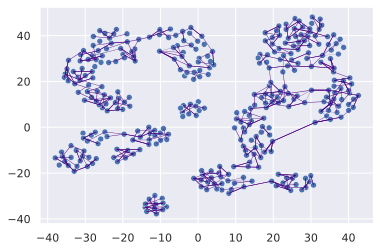

In [23]:
mc.pl.compute_umap_by_features(metacells, max_top_feature_genes=1000,
                               min_dist=5.0, random_seed=123456) # INCREASE min_dist TO GET COMPACTION

umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')

umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, 'obs_outgoing_weights'))
min_long_edge_size = 4
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y)
for (source_index, target_index, weight) \
        in zip(umap_edges.row, umap_edges.col, umap_edges.data):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

In [ ]:
outliers = mc.pl.compute_for_mcview(adata=clean, gdata=metacells, 
                                    random_seed=123456, 
                                    compute_var_var_similarity=dict(top=50, bottom=50))

set PBMC.metacells.var[top_feature_gene]: 807 true (4.007%) out of 20142 bools
set PBMC.metacells.obsp[obs_balanced_ranks]: 4440 nonzero (3.37%) out of 131769 elements
set PBMC.metacells.obsp[obs_pruned_ranks]: 1462 nonzero (1.11%) out of 131769 elements
set PBMC.metacells.obsp[obs_outgoing_weights]: 1462 nonzero (1.11%) out of 131769 elements
set PBMC.metacells.obsp[umap_distances]: csr_matrix 363 X 363 float32s (131406 > 0)
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
set PBMC.metacells.obs[umap_x]: 363 float32s
set PBMC.metacells.obs[umap_y]: 363 float32s
set PBMC.metacells.var[top_feature_gene]: 807 true (4.007%) out of 20142 bools
set PBMC.metacells.obsp[obs_balanced_ranks]: 4440 nonzero (3.37%) out of 131769 elements
set PBMC.metacells.obsp[obs_pruned_ranks]: 1462 nonzero (1.11%) out of 131769

In [ ]:
clean.write('/net/mraid14/export/tgdata/users/hernan/wd_NEW/scrna_db/mat.SynEmb3.h5ad')
metacells.write('/net/mraid14/export/tgdata/users/hernan/wd_NEW/scrna_db/mc.SynEmb3.h5ad')